# Reorganizing the Data

In [ ]:
import pandas as pd
import os

servers = ["Server_1", "Server_2", "Server_3", "Server_4", "Server_5", "Server_6"]

days = ["Day_1", "Day_2", "Day_3", "Day_4", "Day_5", "Day_6", "Day_7", "Day_8", "Day_9", "Day_10", "Day_11", "Day_12", "Day_13", "Day_14"]

columns = ["node_load1",
           "node_memory_MemAvailable_bytes",
           "node_network_transmit_bytes_total{device=\"eno1\"}"]

for server in servers:
    for day in days:
        if not os.path.exists(f"{server}_Training_Sets/{day}.xlsx"):
            server_metrics_df = pd.read_csv(f"Training_Sets/Training_Set_{day}/physical_level/{server.lower()}.csv", usecols=columns, sep=";")

            for column in columns:
                server_metrics_df[column] = pd.to_numeric(server_metrics_df[column], errors='coerce')

            server_metrics_df.to_excel(f"{server}_Training_Sets/{day}.xlsx", index=False)

# Dataset Formation

In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

def greedy_coreset_selection_batch(time_series_df, num_samples, batch_size=10):
    # Remover linhas com NaNs em X ou y
    time_series_df = time_series_df.dropna(subset=['X', 'y'])
    
    X = time_series_df[['X']].values  # valores atuais (input)
    y = time_series_df['y'].values  # valores futuros (rótulos)

    selected_indices = [np.random.randint(0, len(X))]
    remaining_indices = list(set(range(len(X))) - set(selected_indices))

    model = LinearRegression()

    model.fit(X[selected_indices], y[selected_indices])

    pbar = tqdm(total=num_samples, desc="Seleção do Coreset", unit="batch")

    while len(selected_indices) < num_samples:
        max_reduction_in_error = -np.inf
        best_candidate_indices = None

        batch_size_to_use = min(batch_size, len(remaining_indices))
        batch_candidates = np.random.choice(remaining_indices, size=batch_size_to_use, replace=False)

        temporary_coreset = X[selected_indices + list(batch_candidates)]
        temporary_labels = np.concatenate([y[selected_indices], y[batch_candidates]])

        # Verificar se há NaN em temporary_coreset ou temporary_labels
        if np.any(np.isnan(temporary_coreset)) or np.any(np.isnan(temporary_labels)):
            continue  # Ignorar esta iteração se houver NaNs nos dados temporários

        model.fit(temporary_coreset, temporary_labels)

        error = np.mean((model.predict(X[selected_indices + list(batch_candidates)]) - y[selected_indices + list(batch_candidates)]) ** 2)

        error_reduction = error - max_reduction_in_error
        if error_reduction > max_reduction_in_error:
            max_reduction_in_error = error_reduction
            best_candidate_indices = batch_candidates

        selected_indices.extend(best_candidate_indices)
        remaining_indices = list(set(remaining_indices) - set(best_candidate_indices))

        pbar.update(batch_size_to_use)

    pbar.close()

    return time_series_df.iloc[selected_indices]

# Exemplo de uso
# time_series_df = pd.DataFrame({'X': [1, 2, 3, 4, 5], 'y': [5, 4, np.nan, 2, 1]})
# coreset_df = greedy_coreset_selection_batch(time_series_df, num_samples=10, batch_size=2)
# print(coreset_df)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

days = ["Day_1", "Day_2", "Day_3", "Day_4", "Day_5", "Day_6", "Day_7", "Day_8", "Day_9", "Day_10", "Day_11", "Day_12", "Day_13", "Day_14"]

global_coreset_df = pd.DataFrame()

for day in days:

    server_metrics_df = pd.read_excel(f"Server_1_Training_Sets/{day}.xlsx")

    step = 400  # 1 minuto a frente equivale a 395 amostras a frente no timestamp

    #dataset = np.array(server_metrics_df["node_load1"])
    #dataset = np.array(server_metrics_df["node_network_transmit_bytes_total{device=\"eno1\"}"])
    dataset = np.array(server_metrics_df["node_memory_MemAvailable_bytes"])
    
    # Para obter a diferença entre dois períodos (derivada) no atributo de REDE.
    #dataset = pd.Series([dataset[idx + 1] - dataset[idx] for idx in range(len(dataset) - 1)])
    
    dataset = dataset.drop_duplicates().reset_index(drop=True)

    X, y = [], []

    for i in range(len(dataset) - step):
        feature = dataset[i]
        target = dataset[i + step]
        X.append(feature)
        y.append(target)

    time_series_df = pd.DataFrame(columns=["X", "y"], data=[(X_v, y_v) for X_v, y_v in zip(X, y)])

    num_samples = 10000  # Número de amostras que você quer selecionar
    batch_size = 1000

    coreset_df = greedy_coreset_selection_batch(time_series_df, num_samples, batch_size)

    global_coreset_df = pd.concat([global_coreset_df, coreset_df], ignore_index=True)

print(global_coreset_df)

In [62]:
global_coreset_df.describe()

,X,y
count,1.400140e+05,1.400140e+05
mean,2.337162e+07,-2.100642e+07
std,8.304344e+09,8.301149e+09
min,0.000000e+00,-3.106160e+12
25%,1.100895e+06,1.100244e+06
50%,1.184733e+06,1.184515e+06
75%,1.246726e+06,1.246861e+06
max,3.107358e+12,1.516260e+06


In [63]:
global_coreset_df.to_excel("node_memory_MemAvailable_bytes.xlsx", index=False)

# Dataset Treatment

In [12]:
import pandas as pd

# Carregar o dataset
dataset = pd.read_excel("Server_1_Training_Sets/node_memory_MemAvailable_bytes.xlsx")

# Exibir as primeiras linhas para ver a estrutura do dataset (se necessário)
print(dataset.head())

# Calcular a média e o desvio padrão para as colunas X e Y
mean_X = dataset['X'].mean()
std_X = dataset['X'].std()
mean_Y = dataset['y'].mean()
std_Y = dataset['y'].std()

# Definir os limites de 3 desvios padrões da média
lower_limit_X = mean_X - 3 * std_X
upper_limit_X = mean_X + 3 * std_X
lower_limit_Y = mean_Y - 3 * std_Y
upper_limit_Y = mean_Y + 3 * std_Y

# Filtrar os dados dentro de 3 desvios padrão para X e Y
filtered_X = dataset[(dataset['X'] >= lower_limit_X) & (dataset['X'] <= upper_limit_X)]
filtered_Y = dataset[(dataset['y'] >= lower_limit_Y) & (dataset['y'] <= upper_limit_Y)]

# Encontrar o maior valor dentro dos limites para X e Y
max_X = filtered_X['X'].max()
max_Y = filtered_Y['y'].max()

# Exibir os resultados
print(f"Maior valor de X dentro de 3 desvios padrões: {max_X}")
print(f"Maior valor de Y dentro de 3 desvios padrões: {max_Y}")

              X             y
0  143926312960  143923728384
1  149825961984  149806800896
2  142787567616  142786998272
3  142826950656  142825426944
4  147390894080  147383529472
Maior valor de X dentro de 3 desvios padrões: 155046576128
Maior valor de Y dentro de 3 desvios padrões: 154698473472


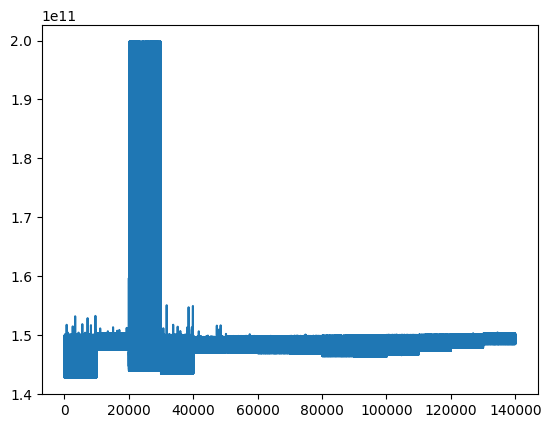

In [13]:
plt.plot(dataset["X"])

In [14]:
# Para CPU
#dataset = dataset / max([max_X, max_Y])

# Para RAM
dataset = dataset / max([max_X, max_Y])
dataset = 1 - dataset
dataset[dataset < 0] = 0


# Para Rede
#dataset = dataset / max([max_X, max_Y])

dataset

,X,y
0,0.071722,0.071739
1,0.033671,0.033795
2,0.079067,0.079070
3,0.078813,0.078822
4,0.049377,0.049424
...,...,...
140009,0.042613,0.042623
140010,0.041604,0.041585
140011,0.041964,0.041950
140012,0.042460,0.042458


In [15]:
dataset.describe()

,X,y
count,140014.000000,140014.000000
mean,0.046599,0.046596
std,0.010483,0.010484
min,0.000000,0.000000
25%,0.039360,0.039360
50%,0.046413,0.046414
75%,0.051536,0.051535
max,0.079140,0.079134


In [16]:
dataset.to_excel("Server_1_Training_Sets/ram_usage.xlsx", index=False)